<a href="https://colab.research.google.com/github/robonoff/Unsupervised-Learning/blob/main/prova2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
import pandas as pd


In [ ]:
class ManifoldSculpting:
    def __init__(self, n_neighbors=10, n_components=2, sigma=0.995, tol=1e-7, max_iter=200):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.sigma = sigma  # Scaling factor for each iteration
        self.tol = tol  # Tolerance for convergence
        self.max_iter = max_iter  # Maximum number of iterations

    def fit_transform(self, X):
        # Step 1: Find the k-nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors, n_jobs=-1, algorithm='auto').fit(X)
        distances, indices = nbrs.kneighbors(X)
        original_distances = distances.copy()
        avg_distance = np.mean(original_distances)

        # Step 3: Optionally apply PCA (accelerates convergence)
        pca = PCA(n_components=self.n_components)
        X_pca = pca.fit_transform(X)

        # Initialize variables for scaling dimensions
        D_pres = X_pca.copy()  # Dimensions to be preserved
        D_scal = X_pca.copy()  # Dimensions to be scaled

        # Iterate until convergence
        for iteration in range(self.max_iter):
            # Step 4a: Scale the dimensions to be eliminated
            D_scal = D_scal * self.sigma

            # Step 4b: Restore original relationships
            error = self._restore_relationships(D_pres, indices, original_distances, avg_distance)

            # Check convergence
            if error < self.tol:
                print(f"Converged after {iteration+1} iterations")
                break

        # Step 5: Project by dropping scaled dimensions
        return D_pres

    def _restore_relationships(self, X, indices, original_distances, avg_distance):
        total_error = 0
        n_samples = X.shape[0]

        # Adjust each point
        for i in range(n_samples):
            neighbors = indices[i, 1:]  # Exclude the point itself
            for j, neighbor in enumerate(neighbors):
                # Compute current distance between point i and its neighbor
                current_dist = np.linalg.norm(X[i] - X[neighbor])
                original_dist = original_distances[i, j]

                # Check if distances are valid
                if current_dist == 0 or np.isnan(current_dist) or np.isinf(current_dist):
                    continue  # Skip invalid updates

                # Compute error based on distances
                delta_dist = (current_dist - original_dist) / (2 * avg_distance)
                adjustment = np.clip(delta_dist * (X[i] - X[neighbor]), -0.1, 0.1)

                # Apply adjustments (ensure no NaN values)
                if not np.isnan(adjustment).any():
                    X[i] -= adjustment
                    X[neighbor] += adjustment

                total_error += delta_dist ** 2

        return total_error


In [ ]:
# Generate Swiss Roll dataset
def generate_swiss_roll(n_samples=2500):  # Increased samples for better precision
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    h = 21 * np.random.rand(1, n_samples)
    X = np.concatenate((t * np.cos(t), h, t * np.sin(t)), axis=0).T
    color = t.flatten()
    return X, color

# Plot function
def plot_mse_comparison(errors, n_neighbors_range):
    plt.figure(figsize=(10, 6))
    for name, err in errors.items():
        plt.plot(n_neighbors_range, err, label=name)
    plt.yscale('log')
    plt.xscale('linear')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Comparison of Dimensionality Reduction Algorithms on Swiss Roll')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

Evaluating with 20 neighbors
Manifold Sculpting, Neighbors: 20, MSE: 43.210200108242816
Isomap, Neighbors: 20, MSE: 349.7825027543258
LLE, Neighbors: 20, MSE: 48.62815827672089
HLLE, Neighbors: 20, MSE: 48.625060537855276
Evaluating with 28 neighbors
Manifold Sculpting, Neighbors: 28, MSE: 45.36376114984341
Isomap, Neighbors: 28, MSE: 346.15429559792966
LLE, Neighbors: 28, MSE: 48.62470051824685
HLLE, Neighbors: 28, MSE: 48.53951458236398
Evaluating with 40 neighbors
Manifold Sculpting, Neighbors: 40, MSE: 37.318962238699086
Isomap, Neighbors: 40, MSE: 194.36087131121704
LLE, Neighbors: 40, MSE: 48.525811127848755
HLLE, Neighbors: 40, MSE: 48.5750354110896
Evaluating with 57 neighbors
Manifold Sculpting, Neighbors: 57, MSE: 43.82175264762511
Isomap, Neighbors: 57, MSE: 196.40022071614837
LLE, Neighbors: 57, MSE: 48.64416700969578
HLLE, Neighbors: 57, MSE: 48.60882610094198
Evaluating with 80 neighbors
Manifold Sculpting, Neighbors: 80, MSE: 52.20542796548803
Isomap, Neighbors: 80, MSE:

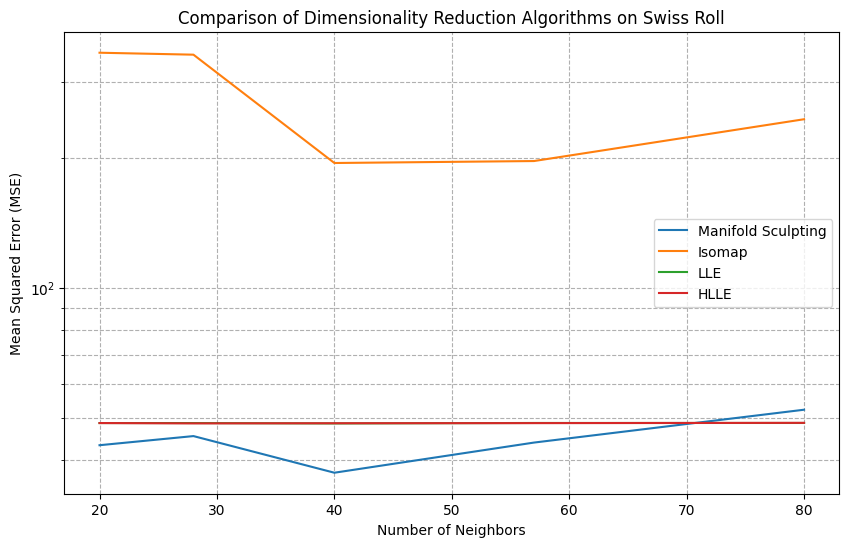

In [ ]:
# Funzione per creare la tabella dei risultati
def create_mse_table(errors, n_neighbors_range):
    # Crea un DataFrame con i dati di MSE per ogni algoritmo e ogni numero di neighbors
    mse_table = pd.DataFrame(errors, index=n_neighbors_range)

    # Rinomina le colonne per indicare chiaramente che si tratta di MSE
    mse_table.index.name = "Number of Neighbors"
    mse_table.columns = [f"MSE ({algorithm})" for algorithm in mse_table.columns]

    # Stampa la tabella
    print(mse_table)

    # Restituisci la tabella come DataFrame
    return mse_table

# Main function to run the test
def run_comparison():
    X, color = generate_swiss_roll()

    # Range of neighbors to test (matching the paper's range)
    n_neighbors_range = [20, 28, 40, 57, 80]



    # Algorithms to compare
    algorithms = {
        'Manifold Sculpting': ManifoldSculpting(max_iter=200),  # Increased iterations for precision
        'Isomap': Isomap(n_components=2, n_jobs=-1),
        'LLE': LocallyLinearEmbedding(n_components=2, n_neighbors=10, n_jobs=-1),  # Reduced reg for LLE
        'HLLE': LocallyLinearEmbedding(n_components=2, method='hessian', n_jobs=-1) # HLLE optimized
    }

    # Dictionary to store MSE results for each algorithm
    errors = {name: [] for name in algorithms}

    # Iterate over different numbers of neighbors
    for n_neighbors in n_neighbors_range:
        print(f"Evaluating with {n_neighbors} neighbors")
        for name, algorithm in algorithms.items():
            # Adjust number of neighbors for each algorithm
            if hasattr(algorithm, 'n_neighbors'):
                algorithm.n_neighbors = n_neighbors

            # Perform dimensionality reduction
            #X_reduced = algorithm.fit_transform(X)

            try:
                X_reduced = algorithm.fit_transform(X)
            except Exception as e:
                print(f"Error with {name}: {e}")
                continue

            # Calculate mean squared error (MSE) by comparing with true manifold structure
            mse = mean_squared_error(X[:, [0, 2]], X_reduced)
            errors[name].append(mse)
            print(f"{name}, Neighbors: {n_neighbors}, MSE: {mse}")

    # Salva i risultati MSE in un file CSV
    mse_df = pd.DataFrame(errors, index=n_neighbors_range)
    mse_df.index.name = "Number of Neighbors"
    mse_df.to_csv("mse_results.csv")

    # Plot the results
    plot_mse_comparison(errors, n_neighbors_range)

if __name__ == "__main__":
    run_comparison()

In [ ]:
# Funzione per creare la tabella dai risultati salvati in un file CSV
def create_mse_table_from_csv(csv_file="mse_results.csv"):
    # Carica i risultati dal CSV
    mse_df = pd.read_csv(csv_file, index_col="Number of Neighbors")

    # Stampa la tabella
    print(mse_df)

    # Restituisci il DataFrame se vuoi usarlo altrove
    return mse_df

# Esempio di utilizzo della funzione
if __name__ == "__main__":
    mse_table = create_mse_table_from_csv("mse_results.csv")

                     Manifold Sculpting      Isomap        LLE       HLLE
Number of Neighbors                                                      
20                            43.210200  349.782503  48.628158  48.625061
28                            45.363761  346.154296  48.624701  48.539515
40                            37.318962  194.360871  48.525811  48.575035
57                            43.821753  196.400221  48.644167  48.608826
80                            52.205428  245.403377  48.645957  48.678481


In [ ]:
# Generate S-curve dataset
def generate_s_curve(n_samples=2500):
    X, _ = make_s_curve(n_samples)
    return X

Evaluating with 250 points
Manifold Sculpting, Points: 250, MSE: 1.8050684852871446
Isomap, Points: 250, MSE: 5.199404838699039
LLE, Points: 250, MSE: 1.261234311966952
HLLE, Points: 250, MSE: 1.2522783447938086
Evaluating with 350 points
Manifold Sculpting, Points: 350, MSE: 2.6921391555653207
Isomap, Points: 350, MSE: 4.9293616844206944
LLE, Points: 350, MSE: 1.2219175562880575
HLLE, Points: 350, MSE: 1.2148377091527707
Evaluating with 500 points
Manifold Sculpting, Points: 500, MSE: 2.462989493692291
Isomap, Points: 500, MSE: 4.995774715739383
LLE, Points: 500, MSE: 1.2460182986577508
HLLE, Points: 500, MSE: 1.2379415349822043
Evaluating with 700 points
Manifold Sculpting, Points: 700, MSE: 2.4705268521027994
Isomap, Points: 700, MSE: 5.257268695467076
LLE, Points: 700, MSE: 1.2369908014182442
HLLE, Points: 700, MSE: 1.240515728137905
Evaluating with 1000 points
Manifold Sculpting, Points: 1000, MSE: 2.2887281986442565
Isomap, Points: 1000, MSE: 5.422161041291965
LLE, Points: 1000, 

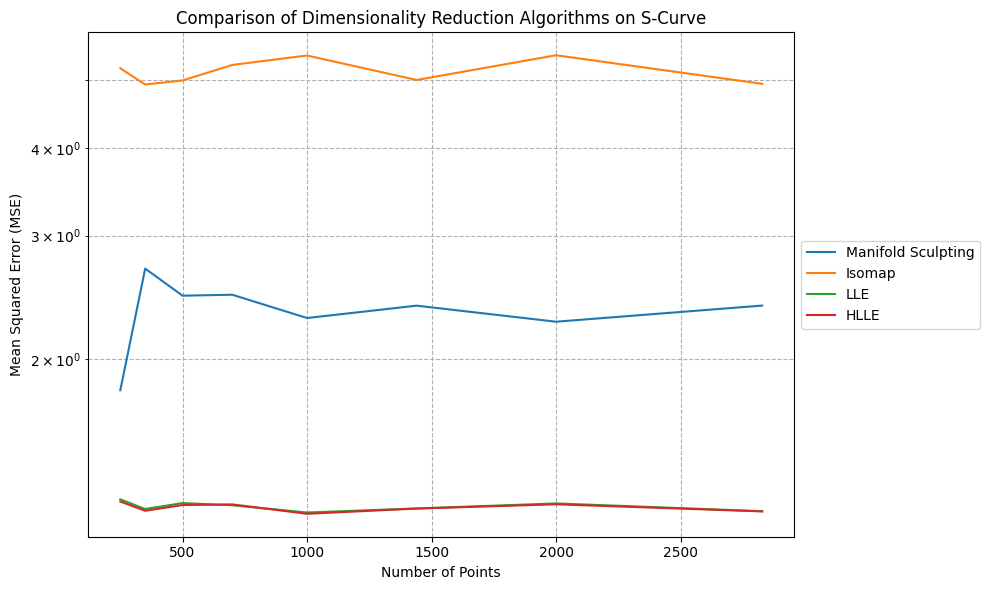

In [ ]:

# Plot function for logarithmic error scaling
def plot_mse_comparison(errors, n_points_range):
    plt.figure(figsize=(10, 6))
    for name, err in errors.items():
        plt.plot(n_points_range, err, label=name)

    plt.yscale('log')
    plt.xscale('linear')
    plt.xlabel('Number of Points')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Comparison of Dimensionality Reduction Algorithms on S-Curve')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()  # Assicura che tutto il contenuto si adatti bene
    plt.show()


# Main function to run the comparison
def run_comparison_s_curve():
    n_points_range = [250, 350, 500, 700, 1000, 1440, 2000, 2828]  # Number of points as in the paper
    n_neighbors = 20  # Fixed number of neighbors as specified in the paper

    # Algorithms to compare
    algorithms = {
        'Manifold Sculpting': ManifoldSculpting(n_neighbors=n_neighbors, max_iter=200),
        'Isomap': Isomap(n_components=2, n_neighbors=n_neighbors, n_jobs=-1),
        'LLE': LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors, n_jobs=-1),
        'HLLE': LocallyLinearEmbedding(n_components=2, method='hessian', n_neighbors=n_neighbors, n_jobs=-1)
    }

    # Dictionary to store MSE results for each algorithm
    errors = {name: [] for name in algorithms}

    # Iterate over different numbers of points
    for n_points in n_points_range:
        print(f"Evaluating with {n_points} points")
        X = generate_s_curve(n_samples=n_points)

        for name, algorithm in algorithms.items():
            X_reduced = algorithm.fit_transform(X)

            # Calculate mean squared error (MSE)
            mse = mean_squared_error(X[:, [0, 2]], X_reduced)
            errors[name].append(mse)
            print(f"{name}, Points: {n_points}, MSE: {mse}")

    # Salva i risultati MSE in un file CSV
    mse_df = pd.DataFrame(errors, index=n_points_range)
    mse_df.index.name = "Number of Neighbors"
    mse_df.to_csv("mse_results_s_curve.csv")

    # Plot the results
    plot_mse_comparison(errors, n_points_range)

if __name__ == "__main__":
    run_comparison_s_curve()

In [ ]:
# Funzione per creare la tabella dai risultati salvati in un file CSV
def create_mse_table_from_s_curve(csv_file="mse_results_s_curve.csv"):
    # Carica i risultati dal CSV
    mse_df_s_curve = pd.read_csv(csv_file, index_col="Number of Neighbors")

    # Stampa la tabella
    print(mse_df_s_curve)

    # Restituisci il DataFrame se vuoi usarlo altrove
    return mse_df_s_curve

# Esempio di utilizzo della funzione
if __name__ == "__main__":
    mse_table = create_mse_table_from_s_curve("mse_results_s_curve.csv")

                     Manifold Sculpting    Isomap       LLE      HLLE
Number of Neighbors                                                  
250                            1.805068  5.199405  1.261234  1.252278
350                            2.692139  4.929362  1.221918  1.214838
500                            2.462989  4.995775  1.246018  1.237942
700                            2.470527  5.257269  1.236991  1.240516
1000                           2.288728  5.422161  1.207916  1.202842
1440                           2.383485  5.003501  1.224090  1.223685
2000                           2.261063  5.426770  1.244541  1.240942
2828                           2.384177  4.940371  1.213065  1.212322
